In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from tqdm import tqdm

In [2]:
data_loader = BinanceDataLoader(
    data_directory=r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020",
    min_records=30,
    min_volume=1e5,
    start_date="2022-07-01",
    end_date=None
)

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 551 USDT trading pairs
✓ BTCUSDT loaded successfully with 1186 records, avg volume: 339,004
Loaded 516 cryptocurrencies
Filtered 33 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 515 tickers over 1186 dates...
Precomputed returns matrix shape: (1186, 515)
Date range: 2022-07-01 00:00:00 to 2025-09-28 00:00:00


In [3]:
def calculate_volatility_scalar_ewma(current_return, ewma_variance, target_volatility, unscaled_returns_history, 
                                   trading_periods_count, recent_trading_periods, ewma_alpha=0.94, min_periods_ewma=30, 
                                   min_periods_rolling=5, min_recent_periods=5):
    """
    Calculate volatility scalar using EWMA or rolling window estimation
    
    Parameters:
    - current_return: current period unscaled portfolio return
    - ewma_variance: current EWMA variance estimate
    - target_volatility: target annualized volatility (e.g., 0.20 for 20%)
    - unscaled_returns_history: list of historical unscaled returns (non-zero only)
    - trading_periods_count: total count of actual trading periods (excludes bear market)
    - recent_trading_periods: count of recent trading periods since last bear market
    - ewma_alpha: EWMA decay factor (default 0.94)
    - min_periods_ewma: minimum total trading periods before using EWMA
    - min_periods_rolling: minimum periods for rolling window
    - min_recent_periods: minimum recent periods needed to resume EWMA after bear market
    
    Returns:
    - tuple: (scalar, updated_ewma_variance)
    """
    # Update EWMA variance only with actual trading returns (non-zero)
    if current_return != 0.0:  # Only update EWMA with actual trading returns
        if ewma_variance is None:
            # Initialize with first squared return
            updated_ewma_variance = current_return ** 2
        else:
            updated_ewma_variance = ewma_alpha * ewma_variance + (1 - ewma_alpha) * (current_return ** 2)
    else:
        # Don't update EWMA during non-trading periods
        updated_ewma_variance = ewma_variance
    
    # Decide which volatility estimation method to use
    can_use_ewma = (trading_periods_count >= min_periods_ewma and 
                    updated_ewma_variance is not None and 
                    recent_trading_periods >= min_recent_periods)
    
    if can_use_ewma:
        # Use EWMA when we have sufficient total history AND recent trading periods
        realized_vol = np.sqrt(updated_ewma_variance) * np.sqrt(365.25)
        
        if realized_vol == 0 or np.isnan(realized_vol):
            return 1.0, updated_ewma_variance
        
        scalar = target_volatility / realized_vol
        scalar = np.clip(scalar, 0.1, 3.0)
        return scalar, updated_ewma_variance
        
    elif len(unscaled_returns_history) >= min_periods_rolling:
        # Use rolling window for initial buildup or when EWMA doesn't have enough recent data
        rolling_vol = np.std(unscaled_returns_history) * np.sqrt(365.25)
        
        if rolling_vol == 0 or np.isnan(rolling_vol):
            return 1.0, updated_ewma_variance
        
        scalar = target_volatility / rolling_vol
        scalar = np.clip(scalar, 0.1, 3.0)
        return scalar, updated_ewma_variance
        
    else:
        # Default to 1.0 when insufficient data for both methods
        return 1.0, updated_ewma_variance

price = data_loader.get_price_matrix()
price

,1000000BOBUSDT,1000000MOGUSDT,1000BONKUSDT,1000CATUSDT,1000CHEEMSUSDT,1000FLOKIUSDT,1000LUNCUSDT,1000PEPEUSDT,1000RATSUSDT,1000SATSUSDT,...,ZENUSDT,ZEREBROUSDT,ZETAUSDT,ZILUSDT,ZKJUSDT,ZKUSDT,ZORAUSDT,ZRCUSDT,ZROUSDT,ZRXUSDT
2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.130,NaN,NaN,0.04079,NaN,NaN,NaN,NaN,NaN,0.3050
2022-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.615,NaN,NaN,0.03893,NaN,NaN,NaN,NaN,NaN,0.3000
2022-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.690,NaN,NaN,0.03866,NaN,NaN,NaN,NaN,NaN,0.2961
2022-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.912,NaN,NaN,0.03994,NaN,NaN,NaN,NaN,NaN,0.3009
2022-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.579,NaN,NaN,0.03897,NaN,NaN,NaN,NaN,NaN,0.3010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-24,0.04602,0.6957,0.020222,0.007291,0.001177,0.08524,0.05534,0.009634,0.02697,0.000037,...,6.896,0.01758,0.1739,0.01083,0.1428,0.05053,0.06199,0.02197,2.1584,0.2414
2025-09-25,0.03969,0.6251,0.018832,0.006682,0.001087,0.07970,0.05277,0.009068,0.02753,0.000040,...,6.246,0.01732,0.1638,0.01017,0.1288,0.04684,0.05940,0.02066,2.1503,0.2271
2025-09-26,0.04131,0.6556,0.019647,0.006950,0.001110,0.08311,0.05418,0.009374,0.02709,0.000051,...,6.405,0.01759,0.1682,0.01042,0.1320,0.04989,0.05722,0.02135,2.3594,0.2385
2025-09-27,0.04037,0.6443,0.019091,0.007163,0.001106,0.08146,0.05396,0.009237,0.02960,0.000043,...,6.379,0.01759,0.1660,0.01040,0.1289,0.05003,0.05671,0.02113,2.2863,0.2358


In [4]:
def run_momentum_strategy_lagged_drift_weighted(price, data_loader, n=14, k=10, n_universe=50, vol_window=30, holding_period=1, 
                         target_volatility=None, ewma_alpha=0.94, drift_threshold=0.08):
    """
    Run momentum strategy with LAGGED calculations and portfolio drift-weighted rebalancing
    
    Parameters:
    - n: momentum lookback period (LAGGED - excludes current day)
    - k: number of long/short positions
    - n_universe: top volume universe size
    - vol_window: volatility calculation window
    - holding_period: rebalancing frequency 
    - target_volatility: target annualized volatility (e.g., 0.20 for 20%). None = no vol targeting
    - ewma_alpha: EWMA decay factor for volatility estimation (default 0.94)
    - drift_threshold: portfolio drift threshold for rebalancing (default 0.08 = 8%)
    """
    equity = [1.0]
    unscaled_returns = []  # Track ALL unscaled portfolio returns (including zeros)
    vol_scalars = []  # Track volatility scalars over time
    ewma_variance = None  # EWMA variance state
    ewma_volatilities = []  # Track EWMA volatility estimates
    trading_periods_count = 0  # Count total actual trading periods
    recent_trading_periods = 0  # Count recent trading periods since last bear market
    vol_method_used = []  # Track which method was used
    
    # Portfolio tracking for drift-weighted rebalancing
    target_weights = {ticker: 0.0 for ticker in price.columns}  # Target allocations
    current_weights = {ticker: 0.0 for ticker in price.columns}  # Current allocations
    initial_prices = {ticker: 0.0 for ticker in price.columns}  # Prices when positions established
    last_rebalance_date = None
    drift_values = []  # Track portfolio drift over time
    rebalance_signals = []  # Track when rebalancing occurs
    
    # Get volume data for universe selection with 20-day rolling average
    volume_data = {}
    for ticker in data_loader.get_universe():
        ticker_data = data_loader._crypto_universe[ticker]['data']
        volume_data[ticker] = ticker_data['volume'].reindex(price.index)

    volume_matrix = pd.DataFrame(volume_data, index=price.index)
    rolling_volume_matrix = volume_matrix.rolling(window=20, min_periods=10).mean()

    # Calculate rolling volatility for weighting
    volatility = price.pct_change().rolling(vol_window).std()

    # Calculate BTC 90-day total return for market filter
    btc_90d_return = price["BTCUSDT"].pct_change(90)

    def calculate_lagged_momentum(current_date, lookback_days):
        """Calculate LAGGED momentum excluding current day"""
        # Find data up to (but not including) current date
        lagged_data = price[price.index < current_date]
        if len(lagged_data) < lookback_days + 1:
            return pd.Series(dtype=float)
        
        # Calculate momentum using lagged data
        end_price = lagged_data.iloc[-1]  # Most recent lagged price
        start_price = lagged_data.iloc[-lookback_days-1]  # Start price for momentum
        momentum = (end_price / start_price) - 1
        return momentum.dropna()

    def calculate_portfolio_drift():
        """Calculate weighted portfolio drift"""
        if sum(abs(w) for w in target_weights.values()) < 1e-6:
            return 0.0
        
        # Calculate current weights based on price movements
        total_portfolio_value = 0.0
        current_values = {}
        
        for ticker in target_weights:
            if target_weights[ticker] != 0 and initial_prices[ticker] > 0:
                current_price = price[ticker].iloc[-1] if len(price) > 0 else initial_prices[ticker]
                price_multiplier = current_price / initial_prices[ticker]
                current_value = target_weights[ticker] * price_multiplier
                current_values[ticker] = current_value
                total_portfolio_value += abs(current_value)
        
        if total_portfolio_value < 1e-6:
            return 0.0
        
        # Calculate weighted drift
        weighted_drift_sum = 0.0
        total_weight = 0.0
        
        for ticker in target_weights:
            if abs(target_weights[ticker]) > 1e-6:
                target_prop = target_weights[ticker] / sum(abs(w) for w in target_weights.values())
                current_prop = current_values.get(ticker, 0.0) / total_portfolio_value
                
                per_asset_drift = abs((current_prop - target_prop) / target_prop) if target_prop != 0 else 0
                position_weight = abs(target_weights[ticker])
                
                weighted_drift_sum += per_asset_drift * position_weight
                total_weight += position_weight
        
        return weighted_drift_sum / total_weight if total_weight > 0 else 0.0

    def should_rebalance(current_date):
        """Determine if portfolio should rebalance based on drift threshold"""
        # Force rebalance if no positions yet
        if sum(abs(w) for w in target_weights.values()) < 1e-6:
            return True
        
        # Check drift threshold
        drift = calculate_portfolio_drift()
        return drift > drift_threshold

    for i in range(n, len(price) - holding_period):
        current_date = price.index[i]

        # BTC Market Filter: Skip trading if BTC 90-day return is negative
        if not pd.isna(btc_90d_return.iloc[i]) and btc_90d_return.iloc[i] < 0:
            equity.append(equity[-1])  # Hold cash during crypto bear markets
            unscaled_returns.append(0.0)  # No return when holding cash
            
            # Clear positions during bear market
            for ticker in target_weights:
                target_weights[ticker] = 0.0
                current_weights[ticker] = 0.0
            
            recent_trading_periods = 0
            vol_scalar = 0.0
            current_ewma_vol = np.sqrt(ewma_variance) * np.sqrt(365.25) if ewma_variance is not None else 0.0
            method_used = 'bear_market'
            drift = 0.0
            rebalanced = False
                
            vol_scalars.append(vol_scalar)
            ewma_volatilities.append(current_ewma_vol)
            vol_method_used.append(method_used)
            drift_values.append(drift)
            rebalance_signals.append(rebalanced)
            continue

        # Check if we should rebalance (drift-based)
        should_rebal = should_rebalance(current_date)
        rebalance_signals.append(should_rebal)
        
        if should_rebal:
            # Get LAGGED volume universe (excluding current day)
            lagged_volumes = rolling_volume_matrix[rolling_volume_matrix.index < current_date]
            if len(lagged_volumes) == 0:
                current_volumes = pd.Series(dtype=float)
            else:
                current_volumes = lagged_volumes.iloc[-1].dropna()

            # Select top N_universe by LAGGED volume
            if len(current_volumes) > 0:
                top_volume_tickers = current_volumes.nlargest(n_universe).index

                # Get LAGGED momentum returns
                momentum_scores = calculate_lagged_momentum(current_date, n)
                filtered_momentum = momentum_scores[momentum_scores.index.intersection(top_volume_tickers)]

                if len(filtered_momentum) >= k * 2:  # Need enough for long and short
                    # Momentum ranking: top performers go long, bottom performers go short
                    long_coins = filtered_momentum.nlargest(k).index
                    short_coins = filtered_momentum.nsmallest(k).index

                    # Get LAGGED volatility for weighting
                    lagged_vol_data = volatility[volatility.index < current_date]
                    if len(lagged_vol_data) > 0:
                        latest_vol = lagged_vol_data.iloc[-1]
                        
                        # Calculate inverse volatility weights
                        long_weights_raw = {}
                        short_weights_raw = {}
                        
                        for ticker in long_coins:
                            if ticker in latest_vol.index and latest_vol[ticker] > 0:
                                long_weights_raw[ticker] = 1.0 / latest_vol[ticker]
                            else:
                                long_weights_raw[ticker] = 1.0
                        
                        for ticker in short_coins:
                            if ticker in latest_vol.index and latest_vol[ticker] > 0:
                                short_weights_raw[ticker] = 1.0 / latest_vol[ticker]
                            else:
                                short_weights_raw[ticker] = 1.0
                        
                        # Normalize weights
                        long_sum = sum(long_weights_raw.values()) if long_weights_raw else 0
                        short_sum = sum(short_weights_raw.values()) if short_weights_raw else 0
                        
                        # Reset all weights
                        for ticker in target_weights:
                            target_weights[ticker] = 0.0
                        
                        # Set new target weights (before volatility scaling)
                        if long_sum > 0:
                            for ticker, weight in long_weights_raw.items():
                                target_weights[ticker] = 0.5 * (weight / long_sum)
                        
                        if short_sum > 0:
                            for ticker, weight in short_weights_raw.items():
                                target_weights[ticker] = -0.5 * (weight / short_sum)
                        
                        # Store initial prices for drift calculation
                        for ticker in target_weights:
                            if target_weights[ticker] != 0:
                                initial_prices[ticker] = price[ticker].iloc[i]
                        
                        last_rebalance_date = current_date
                        trading_periods_count += 1
                        recent_trading_periods += 1

        # Calculate portfolio return for this period
        portfolio_return = 0.0
        if sum(abs(w) for w in target_weights.values()) > 1e-6:
            for ticker in target_weights:
                if target_weights[ticker] != 0:
                    p0 = price[ticker].iloc[i]
                    p1 = price[ticker].iloc[i + holding_period]
                    if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                        coin_return = (p1 - p0) / p0
                        portfolio_return += target_weights[ticker] * coin_return

        # Subtract fees
        unscaled_portfolio_return = portfolio_return - 0.0005  # 5bps fees
        unscaled_returns.append(unscaled_portfolio_return)
        
        # Apply volatility targeting if specified
        if target_volatility is not None:
            non_zero_returns = [r for r in unscaled_returns if r != 0.0]
            vol_scalar, ewma_variance = calculate_volatility_scalar_ewma(
                unscaled_portfolio_return, ewma_variance, target_volatility, non_zero_returns, 
                trading_periods_count, recent_trading_periods, ewma_alpha)
            final_portfolio_return = unscaled_portfolio_return * vol_scalar
            current_ewma_vol = np.sqrt(ewma_variance) * np.sqrt(365.25) if ewma_variance is not None else 0.0
            
            # Determine method used
            can_use_ewma = (trading_periods_count >= 30 and ewma_variance is not None and recent_trading_periods >= 5)
            if can_use_ewma:
                method_used = 'ewma'
            elif len(non_zero_returns) >= 5:
                method_used = 'rolling'
            else:
                method_used = 'default'
        else:
            vol_scalar = 1.0
            final_portfolio_return = unscaled_portfolio_return
            current_ewma_vol = 0.0
            method_used = 'no_targeting'
        
        # Calculate current portfolio drift
        drift = calculate_portfolio_drift()
        
        vol_scalars.append(vol_scalar)
        ewma_volatilities.append(current_ewma_vol)
        vol_method_used.append(method_used)
        drift_values.append(drift)
        equity.append(equity[-1] * (1 + final_portfolio_return))
    
    # Return as pandas Series with proper index, plus additional info
    equity_series = pd.Series(equity, index=price.index[:len(equity)])
    
    # Return additional data for analysis
    result_dict = {
        'equity': equity_series,
        'unscaled_returns': unscaled_returns,
        'vol_scalars': vol_scalars,
        'ewma_volatilities': ewma_volatilities,
        'target_volatility': target_volatility,
        'ewma_alpha': ewma_alpha,
        'trading_periods_count': trading_periods_count,
        'vol_method_used': vol_method_used,
        'drift_values': drift_values,
        'rebalance_signals': rebalance_signals,
        'drift_threshold': drift_threshold
    }
    
    return result_dict

In [5]:
# Define parameter combinations to test
parameter_sets = [
    # Original strategies without volatility targeting
    {'n': 14, 'k': 10, 'n_universe': 55, 'vol_window': 30, 'holding_period': 1, 'target_volatility': None, 'name': 'Base (14d, 10 pos)'},
    
    # EWMA volatility targeting strategies
    {'n': 14, 'k': 10, 'n_universe': 55, 'vol_window': 30, 'holding_period': 1, 'target_volatility': 0.20, 'ewma_alpha': 0.94, 'name': 'Base + EWMA VolTarget 20%'},
    
    # NEW: Lagged + Drift-Weighted strategies with different drift thresholds
    {'strategy_type': 'lagged_drift', 'n': 14, 'k': 10, 'n_universe': 50, 'vol_window': 20, 'holding_period': 1, 'target_volatility': 0.35, 'ewma_alpha': 0.84, 'drift_threshold': 0.13, 'name': 'Lagged + Drift 13%'},
    {'strategy_type': 'lagged_drift', 'n': 14, 'k': 10, 'n_universe': 50, 'vol_window': 20, 'holding_period': 1, 'target_volatility': 0.35, 'ewma_alpha': 0.84, 'drift_threshold': 0.15, 'name': 'Lagged + Drift 15%'},
    {'strategy_type': 'lagged_drift', 'n': 14, 'k': 10, 'n_universe': 50, 'vol_window': 20, 'holding_period': 1, 'target_volatility': 0.35, 'ewma_alpha': 0.84, 'drift_threshold': 0.11, 'name': 'Lagged + Drift 11%'},
    
    # Comparison: Lagged + Drift vs Original with different parameters
    {'strategy_type': 'lagged_drift', 'n': 7, 'k': 5, 'n_universe': 30, 'vol_window': 20, 'holding_period': 1, 'target_volatility': 0.20, 'ewma_alpha': 0.94, 'drift_threshold': 0.08, 'name': 'Fast Lagged + Drift'},
    {'strategy_type': 'lagged_drift', 'n': 21, 'k': 15, 'n_universe': 70, 'vol_window': 45, 'holding_period': 1, 'target_volatility': 0.20, 'ewma_alpha': 0.94, 'drift_threshold': 0.08, 'name': 'Slow Lagged + Drift'},
]

# Run backtests for all parameter combinations
results = {}
print("Running parameter tests with LAGGED + DRIFT-WEIGHTED strategies...")

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff1744', '#00e676', 
          '#3f51b5', '#ff9800', '#9c27b0', '#795548', '#607d8b', '#4caf50',
          '#f44336', '#2196f3', '#ffeb3b', '#9e9e9e', '#e91e63', '#00bcd4']

for i, params in enumerate(parameter_sets):
    print(f"Testing {params['name']} ({i+1}/{len(parameter_sets)})...")
    
    # Extract parameters (excluding 'name' and 'strategy_type')
    strategy_params = {k: v for k, v in params.items() if k not in ['name', 'strategy_type']}
    
    # Initialize result_dict
    result_dict = None
    
    # Run appropriate strategy
    if params.get('strategy_type') == 'lagged_drift':
        result_dict = run_momentum_strategy_lagged_drift_weighted(price, data_loader, **strategy_params)

    
    # Store result
    if result_dict is not None:
        results[params['name']] = result_dict
    else:
        print(f"Warning: No result for {params['name']}")

print("All backtests completed!")

Running parameter tests with LAGGED + DRIFT-WEIGHTED strategies...
Testing Base (14d, 10 pos) (1/7)...
Testing Base + EWMA VolTarget 20% (2/7)...
Testing Lagged + Drift 13% (3/7)...


C:\Users\USER\AppData\Local\Temp\ipykernel_35176\2054855027.py:43: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatility = price.pct_change().rolling(vol_window).std()


Testing Lagged + Drift 15% (4/7)...


C:\Users\USER\AppData\Local\Temp\ipykernel_35176\2054855027.py:43: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatility = price.pct_change().rolling(vol_window).std()


Testing Lagged + Drift 11% (5/7)...


C:\Users\USER\AppData\Local\Temp\ipykernel_35176\2054855027.py:43: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatility = price.pct_change().rolling(vol_window).std()


Testing Fast Lagged + Drift (6/7)...


C:\Users\USER\AppData\Local\Temp\ipykernel_35176\2054855027.py:43: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatility = price.pct_change().rolling(vol_window).std()


Testing Slow Lagged + Drift (7/7)...


C:\Users\USER\AppData\Local\Temp\ipykernel_35176\2054855027.py:43: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatility = price.pct_change().rolling(vol_window).std()


All backtests completed!


In [6]:
def calculate_performance_metrics(result_dict):
    """Calculate key performance metrics for an equity curve"""
    if isinstance(result_dict, dict):
        equity_series = result_dict['equity']
        unscaled_returns = result_dict['unscaled_returns']
        target_volatility = result_dict['target_volatility']
    else:
        # Backward compatibility for simple equity series
        equity_series = result_dict
        unscaled_returns = None
        target_volatility = None
    
    returns = equity_series.pct_change().dropna()
    
    # Total return
    total_return = (equity_series.iloc[-1] / equity_series.iloc[0]) - 1
    
    # Annualized return (assuming daily data)
    days = len(equity_series)
    years = days / 365.25
    cagr = (equity_series.iloc[-1] / equity_series.iloc[0]) ** (1/years) - 1
    
    # Volatility (annualized)
    volatility = returns.std() * np.sqrt(365.25)
    
    # Sharpe ratio (assuming 0% risk-free rate)
    sharpe = cagr / volatility if volatility > 0 else 0
    
    # Maximum drawdown
    running_max = equity_series.expanding().max()
    drawdown = (equity_series - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calmar ratio
    calmar = cagr / abs(max_drawdown) if max_drawdown < 0 else 0
    
    metrics = {
        'Total Return': f"{total_return:.2%}",
        'CAGR': f"{cagr:.2%}",
        'Volatility': f"{volatility:.2%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}",
        'Calmar Ratio': f"{calmar:.2f}"
    }
    
    # Add volatility targeting metrics if available
    if unscaled_returns and target_volatility:
        # Calculate realized volatility from unscaled returns
        unscaled_vol = np.std(unscaled_returns) * np.sqrt(365.25)
        vol_target_error = abs(volatility - target_volatility)
        
        metrics['Target Vol'] = f"{target_volatility:.2%}"
        metrics['Unscaled Vol'] = f"{unscaled_vol:.2%}"
        metrics['Vol Target Error'] = f"{vol_target_error:.2%}"
    
    return metrics

# Calculate metrics for all strategies
performance_df = pd.DataFrame()
for name, result in results.items():
    metrics = calculate_performance_metrics(result)
    performance_df[name] = metrics

# Add BTC benchmark
btc_cumret = (1 + price["BTCUSDT"].pct_change().fillna(0)).cumprod()
btc_metrics = calculate_performance_metrics(btc_cumret)
performance_df['BTC Benchmark'] = btc_metrics

print("Performance Metrics:")
print(performance_df.T)

Performance Metrics:
                    Total Return     CAGR Volatility Sharpe Ratio  \
Lagged + Drift 13%       -66.57%  -28.93%     31.01%        -0.93   
Lagged + Drift 15%       -66.57%  -28.93%     31.01%        -0.93   
Lagged + Drift 11%       -66.57%  -28.93%     31.01%        -0.93   
Fast Lagged + Drift      -36.84%  -13.27%     18.04%        -0.74   
Slow Lagged + Drift      -52.56%  -20.85%     18.41%        -1.13   
BTC Benchmark            469.70%   70.89%     48.54%         1.46   

                    Max Drawdown Calmar Ratio Target Vol Unscaled Vol  \
Lagged + Drift 13%       -69.14%        -0.42     35.00%       19.15%   
Lagged + Drift 15%       -69.14%        -0.42     35.00%       19.15%   
Lagged + Drift 11%       -69.14%        -0.42     35.00%       19.15%   
Fast Lagged + Drift      -45.46%        -0.29     20.00%       25.99%   
Slow Lagged + Drift      -54.11%        -0.39     20.00%       16.02%   
BTC Benchmark            -35.43%         2.00        NaN 

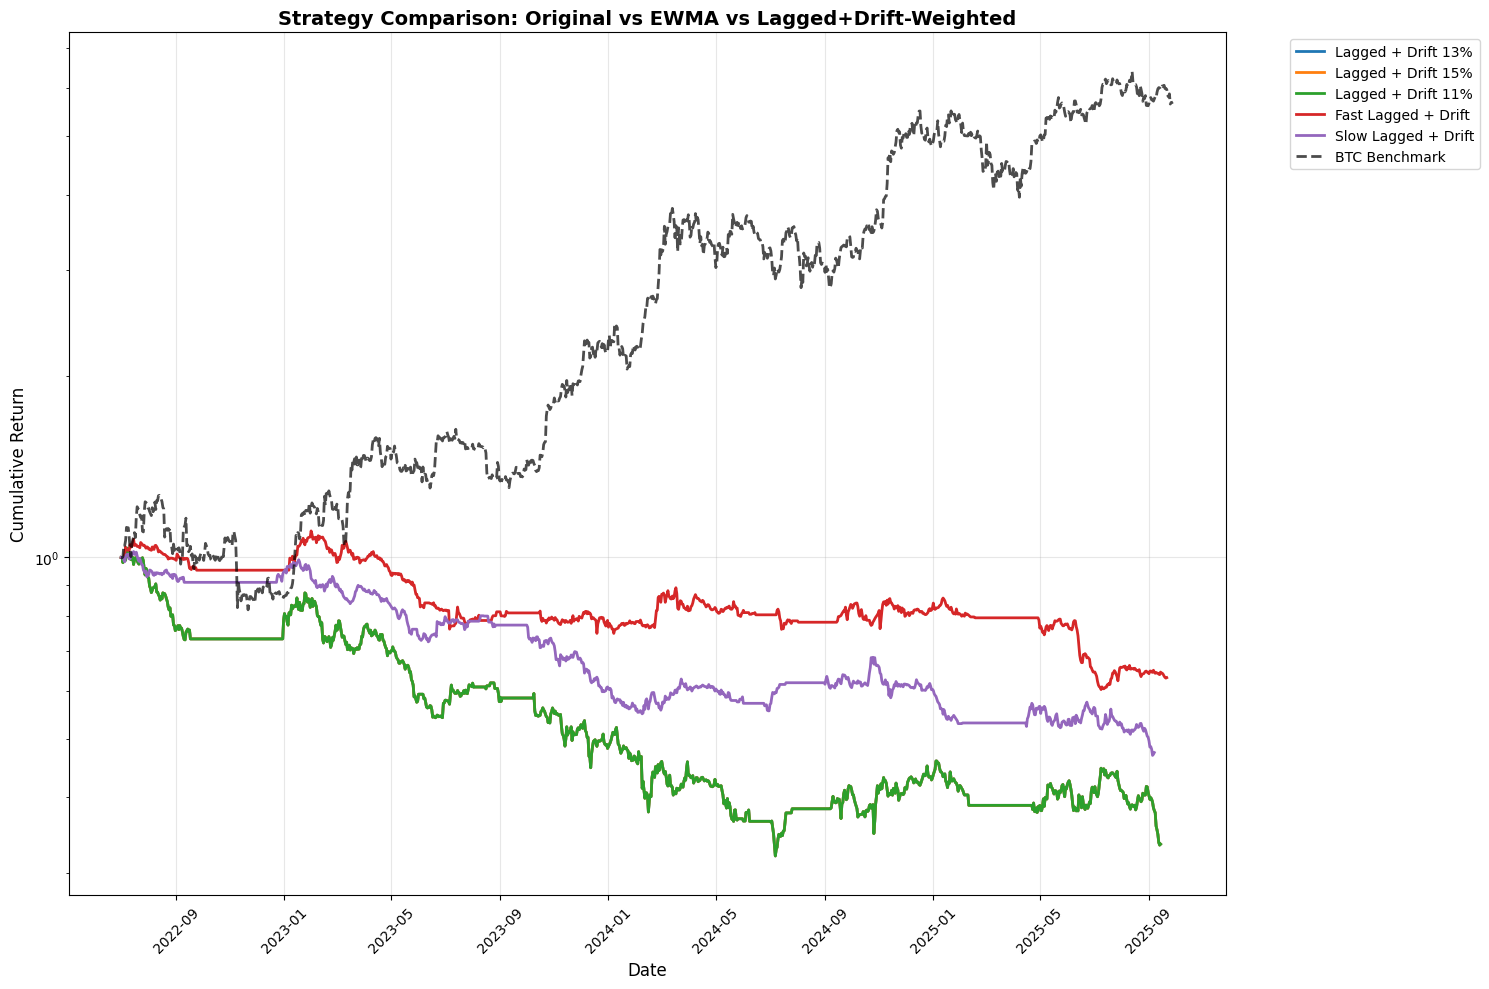

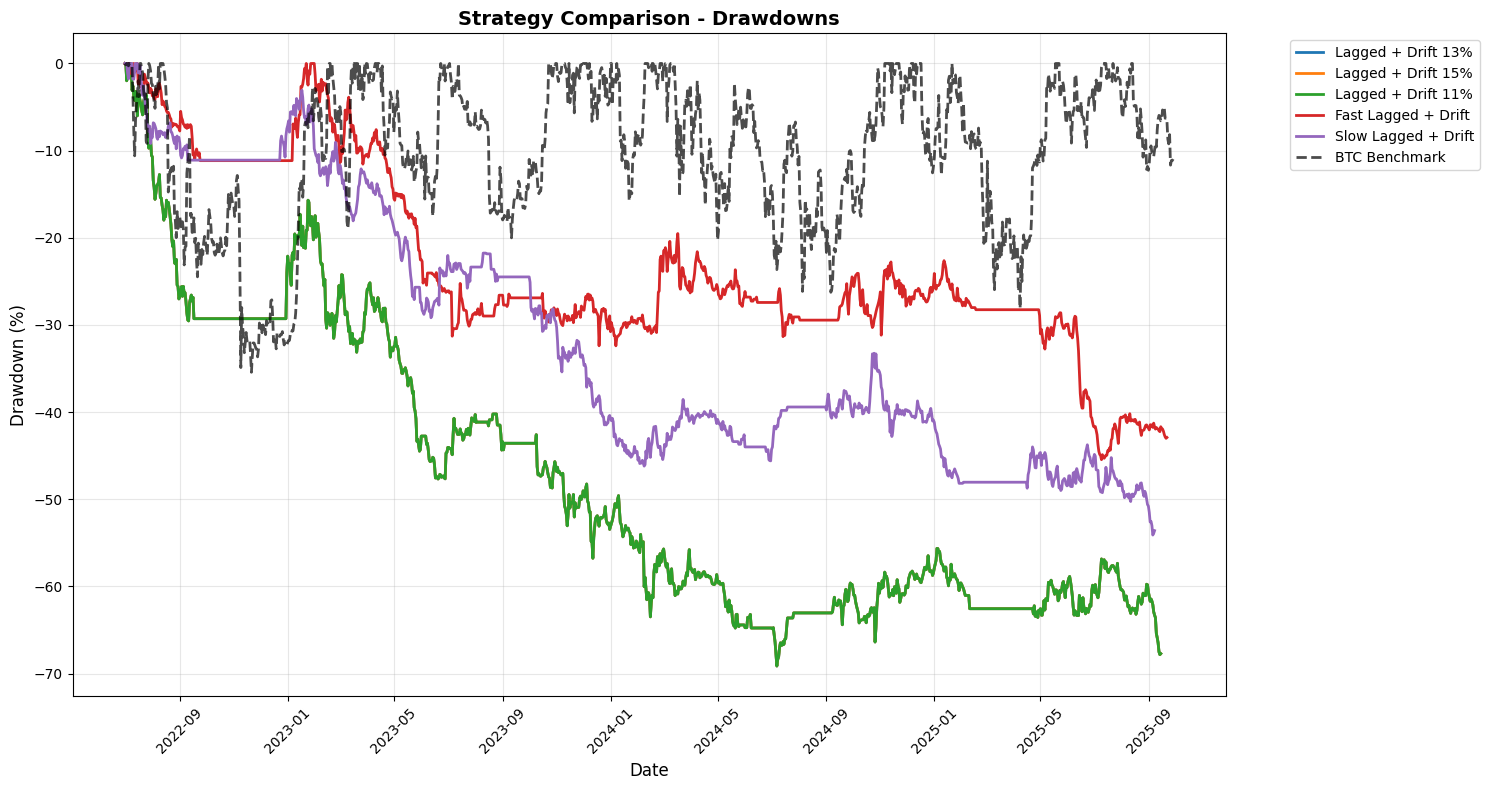

In [ ]:
# Create comprehensive comparison plot
plt.figure(figsize=(15, 10))

# Plot all strategy equity curves
for i, (name, result) in enumerate(results.items()):
    equity = result['equity'] if isinstance(result, dict) else result
    plt.plot(equity.index, equity.values, label=name, linewidth=2, color=colors[i % len(colors)])

# Plot BTC benchmark
btc_cumret = (1 + price["BTCUSDT"].pct_change().fillna(0)).cumprod()
plt.plot(btc_cumret.index, btc_cumret.values, label="BTC Benchmark", 
         linewidth=2, linestyle='--', color='black', alpha=0.7)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.title("Strategy Comparison: Original vs EWMA vs Lagged+Drift-Weighted", fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to better show different performance levels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create drawdown comparison
plt.figure(figsize=(15, 8))

for i, (name, result) in enumerate(results.items()):
    equity = result['equity'] if isinstance(result, dict) else result
    running_max = equity.expanding().max()
    drawdown = (equity - running_max) / running_max * 100
    plt.plot(equity.index, drawdown, label=name, linewidth=2, color=colors[i % len(colors)])

# BTC drawdown
btc_running_max = btc_cumret.expanding().max()
btc_drawdown = (btc_cumret - btc_running_max) / btc_running_max * 100
plt.plot(btc_cumret.index, btc_drawdown, label="BTC Benchmark", 
         linewidth=2, linestyle='--', color='black', alpha=0.7)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Drawdown (%)", fontsize=12)
plt.title("Strategy Comparison - Drawdowns", fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# NEW: Portfolio Drift Analysis for Lagged+Drift strategies
drift_strategies = [(name, result) for name, result in results.items() 
                   if isinstance(result, dict) and 'drift_values' in result]

if drift_strategies:
    fig, axes = plt.subplots(len(drift_strategies), 1, figsize=(15, 4*len(drift_strategies)), sharex=True)
    if len(drift_strategies) == 1:
        axes = [axes]
    
    for i, (name, result) in enumerate(drift_strategies):
        equity = result['equity']
        drift_values = result['drift_values']
        rebalance_signals = result['rebalance_signals']
        drift_threshold = result.get('drift_threshold', 0.08)
        
        ax = axes[i]
        
        # Plot drift values
        drift_index = equity.index[1:len(drift_values)+1]
        ax.plot(drift_index, drift_values, label='Portfolio Drift', color='blue', linewidth=2)
        ax.axhline(y=drift_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({drift_threshold:.0%})')
        
        # Mark rebalancing points
        rebalance_dates = [equity.index[j+1] for j, signal in enumerate(rebalance_signals) if signal and j+1 < len(equity.index)]
        rebalance_drifts = [drift_values[j] for j, signal in enumerate(rebalance_signals) if signal and j < len(drift_values)]
        
        if rebalance_dates:
            ax.scatter(rebalance_dates, rebalance_drifts, color='red', s=50, alpha=0.7, label=f'Rebalance ({len(rebalance_dates)} times)')
        
        ax.set_ylabel('Portfolio Drift', fontsize=11)
        ax.set_title(f'{name} - Portfolio Drift Tracking', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, max(max(drift_values) * 1.1, drift_threshold * 2))
    
    plt.xlabel("Date", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics for drift strategies
    print("📊 PORTFOLIO DRIFT ANALYSIS:")
    for name, result in drift_strategies:
        drift_values = result['drift_values']
        rebalance_signals = result['rebalance_signals']
        drift_threshold = result.get('drift_threshold', 0.08)
        
        avg_drift = np.mean(drift_values)
        max_drift = np.max(drift_values)
        rebalance_count = sum(rebalance_signals)
        
        print(f"\n{name}:")
        print(f"  • Drift Threshold: {drift_threshold:.1%}")
        print(f"  • Average Drift: {avg_drift:.2%}")
        print(f"  • Maximum Drift: {max_drift:.2%}")
        print(f"  • Rebalances: {rebalance_count} times")
        print(f"  • Avg Days Between Rebalances: {len(drift_values)/rebalance_count:.1f}" if rebalance_count > 0 else "  • No rebalances")

# EWMA Volatility targeting plots (updated for both strategy types)
vol_targeted_strategies = [(name, result) for name, result in results.items() 
                          if isinstance(result, dict) and result.get('target_volatility') is not None]

if vol_targeted_strategies:
    n_plots = len(vol_targeted_strategies)
    fig, axes = plt.subplots(n_plots, 1, figsize=(15, 4*n_plots), sharex=True)
    if n_plots == 1:
        axes = [axes]
    
    for i, (name, result) in enumerate(vol_targeted_strategies):
        equity = result['equity']
        vol_scalars = result['vol_scalars']
        ewma_volatilities = result['ewma_volatilities']
        target_vol = result['target_volatility']
        ewma_alpha = result.get('ewma_alpha', 0.94)
        
        # Create index for vol_scalars and ewma_volatilities
        vol_scalar_index = equity.index[1:len(vol_scalars)+1]
        ewma_vol_index = equity.index[1:len(ewma_volatilities)+1]
        
        ax = axes[i]
        
        # Plot volatility scalar
        ax.plot(vol_scalar_index, vol_scalars, label=f'Vol Scalar', color='blue', linewidth=2)
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='No Scaling (1.0)')
        ax.set_ylabel('Vol Scalar', fontsize=11)
        
        strategy_type = "Lagged+Drift" if 'Lagged' in name else "EWMA"
        ax.set_title(f'{name} - {strategy_type} Volatility Targeting (α={ewma_alpha}, Target: {target_vol:.0%})', fontsize=12)
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # Add EWMA volatility estimates on secondary axis
        ax2 = ax.twinx()
        ax2.plot(ewma_vol_index, ewma_volatilities, color='green', alpha=0.8, linewidth=2, label='EWMA Volatility')
        ax2.axhline(y=target_vol, color='orange', linestyle=':', linewidth=2, label=f'Target Vol ({target_vol:.0%})')
        ax2.set_ylabel('Annualized Volatility', fontsize=11, color='green')
        ax2.legend(loc='upper right')
        ax2.tick_params(axis='y', labelcolor='green')
        
        # Set reasonable y-axis limits for volatility
        vol_data = [v for v in ewma_volatilities if v > 0]
        if vol_data:
            ax2.set_ylim(0, max(max(vol_data) * 1.2, target_vol * 2))
    
    plt.xlabel("Date", fontsize=12)
    plt.tight_layout()
    plt.show()

else:
    print("No volatility-targeted strategies found for plotting.")

In [ ]:
# Create ranking summary
print("="*80)
print("STRATEGY RANKING SUMMARY")
print("="*80)

# Extract numeric values for ranking
ranking_data = []
for strategy in performance_df.columns:
    if strategy != 'BTC Benchmark':  # Exclude benchmark from ranking
        metrics = performance_df[strategy]
        ranking_data.append({
            'Strategy': strategy,
            'CAGR': float(metrics['CAGR'].rstrip('%')) / 100,
            'Sharpe': float(metrics['Sharpe Ratio']),
            'Max DD': float(metrics['Max Drawdown'].rstrip('%')) / 100,
            'Calmar': float(metrics['Calmar Ratio']),
            'Vol': float(metrics['Volatility'].rstrip('%')) / 100,
            'Has_VolTarget': 'VolTarget' in strategy
        })

ranking_df = pd.DataFrame(ranking_data)

# Rank by different metrics
print("\n📈 RANKED BY CAGR (Compound Annual Growth Rate):")
cagr_ranked = ranking_df.sort_values('CAGR', ascending=False)
for i, (idx, row) in enumerate(cagr_ranked.iterrows()):
    vol_marker = " 🎯" if row['Has_VolTarget'] else ""
    print(f"{i+1:2d}. {row['Strategy']:30s} {row['CAGR']:8.2%}{vol_marker}")

print("\n📊 RANKED BY SHARPE RATIO:")
sharpe_ranked = ranking_df.sort_values('Sharpe', ascending=False)
for i, (idx, row) in enumerate(sharpe_ranked.iterrows()):
    vol_marker = " 🎯" if row['Has_VolTarget'] else ""
    print(f"{i+1:2d}. {row['Strategy']:30s} {row['Sharpe']:8.2f}{vol_marker}")

print("\n🛡️  RANKED BY MAX DRAWDOWN (Lower is better):")
dd_ranked = ranking_df.sort_values('Max DD', ascending=True)
for i, (idx, row) in enumerate(dd_ranked.iterrows()):
    vol_marker = " 🎯" if row['Has_VolTarget'] else ""
    print(f"{i+1:2d}. {row['Strategy']:30s} {row['Max DD']:8.2%}{vol_marker}")

print("\n🏆 RANKED BY CALMAR RATIO (Risk-adjusted return):")
calmar_ranked = ranking_df.sort_values('Calmar', ascending=False)
for i, (idx, row) in enumerate(calmar_ranked.iterrows()):
    vol_marker = " 🎯" if row['Has_VolTarget'] else ""
    print(f"{i+1:2d}. {row['Strategy']:30s} {row['Calmar']:8.2f}{vol_marker}")

# Best overall strategy (balanced score)
ranking_df['Overall_Score'] = (
    ranking_df['CAGR'].rank(pct=True) * 0.3 +
    ranking_df['Sharpe'].rank(pct=True) * 0.4 +
    ranking_df['Max DD'].rank(pct=True, ascending=False) * 0.2 +
    ranking_df['Calmar'].rank(pct=True) * 0.1
)

print("\n🎯 OVERALL RANKING (Weighted: 30% CAGR, 40% Sharpe, 20% Drawdown, 10% Calmar):")
overall_ranked = ranking_df.sort_values('Overall_Score', ascending=False)
for i, (idx, row) in enumerate(overall_ranked.iterrows()):
    vol_marker = " 🎯" if row['Has_VolTarget'] else ""
    print(f"{i+1:2d}. {row['Strategy']:30s} Score: {row['Overall_Score']:.3f}{vol_marker}")

print("\n" + "="*80)
winner = overall_ranked.iloc[0]
vol_marker = " (with Volatility Targeting)" if winner['Has_VolTarget'] else ""
print(f"🏆 WINNER: {winner['Strategy']}{vol_marker}")
print("="*80)

# Volatility targeting analysis
vol_targeted = ranking_df[ranking_df['Has_VolTarget']]
non_vol_targeted = ranking_df[~ranking_df['Has_VolTarget']]

if len(vol_targeted) > 0 and len(non_vol_targeted) > 0:
    print("\n📊 VOLATILITY TARGETING EFFECTIVENESS:")
    print(f"Average Sharpe Ratio (Vol Targeted): {vol_targeted['Sharpe'].mean():.2f}")
    print(f"Average Sharpe Ratio (Non-Targeted): {non_vol_targeted['Sharpe'].mean():.2f}")
    print(f"Average Volatility (Vol Targeted): {vol_targeted['Vol'].mean():.2%}")
    print(f"Average Volatility (Non-Targeted): {non_vol_targeted['Vol'].mean():.2%}")
    
    # Check if volatility targeting improves risk-adjusted returns
    vol_target_advantage = vol_targeted['Sharpe'].mean() - non_vol_targeted['Sharpe'].mean()
    if vol_target_advantage > 0:
        print(f"✅ Volatility targeting improves average Sharpe ratio by {vol_target_advantage:.2f}")
    else:
        print(f"❌ Volatility targeting reduces average Sharpe ratio by {abs(vol_target_advantage):.2f}")
    print("="*80)